In [1]:
#Generic import Cell

import torch
from torch.autograd import Variable
print(f'Pytorch version {torch.__version__}')

import numpy as np
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec

from time import time
import re
import json

Pytorch version 2.0.1


In [2]:
#Imports local modules used in generating mock data

sys.path.append('../scripts/')
import potential_torch
import flow_torch
import toy_systems
import pot_def

Pytorch version 2.0.1
Pytorch version 2.0.1


# Theory

## Plummer Sphere

The Plummer sphere is a spherically symmetric, self-gravitating system. It has density
$$
  \rho \left( r \right) = \frac{3}{4 \pi} \left( 1 + r^2 \right)^{-\frac{5}{2}} \, ,
$$
which generates the gravitational potential
$$
  \Phi \left( r \right) = \left( 1 + r^2 \right)^{-\frac{1}{2}} \, .
$$
There exists a simple distribution function with isotropic velocities that renders the system stationary. Begin with the specific energy of an individual particle:
$$
  E = \frac{1}{2} v^2 + \Phi \, .
$$
Then, the distribution function
$$
  f \left( E \right) \propto
  \begin{cases}
    \left( -E \right)^{\frac{7}{2}} \, , & E < 0 \\
    0 \, , & E > 0
  \end{cases}
$$
reduces to the above density (after integrating over velocity) and is stationary, since it only depends on a conserved quantity: the energy. Note that because the energy is always negative, all the particles are on bound orbits.
$$
  p \left( E \right) \\
  p \left( E \mid r \right)
$$

$$
  p \left( r \right) \propto r^2 \rho \left( r \right) \\
  p \left( v \mid r \right) \propto v^2 \left[ \left( 1 + r^2 \right)^{-\frac{1}{2}} + \frac{1}{2} v^2 \right]^{\frac{7}{2}}
$$

## Verify stationarity in ideal case

We can verify that the combination of the above distribution function and potential renders the system stationary. Stationarity requires that
$$
  \frac{\partial f}{\partial t}
  = \left\{ \mathcal{H} , f \right\}
  = \sum_i \left(
      \frac{\partial \Phi}{\partial x_i} \frac{\partial f}{\partial v_i}
    - v_i \frac{\partial f}{\partial x_i}
    \right)
  = 0 \, .
$$
In order to empirically verify that this condition holds throughout phase space, we draw random points in phase space (not necessarily from the distribution function - the stationarity relation should hold everywhere in phase space), calculate $\Phi$ and $f$, use pytorch to evaluate the gradients, and finally calculate the above Poisson bracket. It should be zero at every point that we draw.

In [3]:
#Generates a random 10x3 array sampled from a normal gaussian distribution
x = Variable(torch.from_numpy(np.random.normal(size=[10,3])), requires_grad=True)
v = Variable(torch.from_numpy(np.random.normal(size=[10,3])), requires_grad=True)

#Calculates the squared length of each vector in R3
r2 = torch.sum(x**2, axis=1)
v2 = torch.sum(v**2, axis=1)

#Calculates the graviational potential for each particle
Phi = (-(1+r2)**(-1/2))
#Calculates the total Energy associated with each particle
E = v2/2 + Phi

#Ansatz? for distribution function is given by f = -E^(7/2)
#Replaces all elements outside of the bounds with the value of the upper or lower bound.
f = (torch.clamp(-E, 0, np.inf)**(7/2))
print(f)

#Calculates relavent derivatives used in the CBE
df_dv = torch.autograd.grad(f, v,\
                            grad_outputs=torch.ones_like(f), retain_graph=True,\
                            create_graph=True)[0]
df_dx = torch.autograd.grad(f, x,\
                            grad_outputs=torch.ones_like(f), retain_graph=True,\
                            create_graph=True)[0]

dPhi_dx = torch.autograd.grad(Phi, x,\
                            grad_outputs=torch.ones_like(Phi), retain_graph=True,\
                            create_graph=True)[0]

#Verifies this choice of distribution function is stationary
df_dt = torch.sum(dPhi_dx * df_dv - df_dx * v, axis=1)
#print(f'{{H,f}} = {df_dt}')

np.testing.assert_allclose(df_dt.detach().numpy(), 0., atol=1.e-5)

tensor([0.0000, 0.0000, 0.0000, 0.0321, 0.0149, 0.0000, 0.0000, 0.1173, 0.0000,
        0.0000], dtype=torch.float64, grad_fn=<PowBackward0>)


## Mock data

We now draw phase-space points from the Plummer sphere distribution function. This will be used as input data to train a normalizing flow representing the distribution function.

In [4]:
# Instantiate Plummer sphere class
plummer_sphere = toy_systems.PlummerSphere()
print(plummer_sphere)

def sample_df(n_samples, max_dist=None):
    """
    Returns phase-space locations sampled from the Plummer sphere
    distribution function. The shape of the output is
    (n_samples, 6).
    """
    #Generates coordinates in phase-space from that lie in a spherical spatial region.
    x,v = plummer_sphere.sample_df(n_samples)
    if max_dist is not None:
        r2 = np.sum(x**2, axis=1)
        idx = (r2 < max_dist**2)
        x = x[idx]
        v = v[idx]
    
    return torch.cat([torch.Tensor(x.astype('f4')), torch.Tensor(v.astype('f4'))], axis=1)

In [5]:
#Cell used to determine the number of data points used and generate the data.
n_samples = 1024 * 1
data = sample_df(n_samples)
print(data)

tensor([[-0.8316, -0.0586, -0.3041,  0.6076, -0.1160,  0.0988],
        [-0.5029,  0.5045,  0.8257,  0.0388, -0.0429,  0.3838],
        [ 0.8156,  0.6113,  0.5623,  0.4187,  0.4777,  0.1959],
        ...,
        [-1.7556, -0.7461,  0.8019,  0.2120,  0.3952, -0.0669],
        [-0.0670,  0.3688, -0.1202,  0.0890, -0.3459, -0.6264],
        [-0.1297,  0.5080,  0.3484,  0.5761, -0.1089,  0.1639]])


We plot the mock data in a few different projections of phase space:

In [6]:
def vec2ang(x):
    #Used to convert the cartesian coordinates into spherical coordinates.
    phi = np.arctan2(x[:,1], x[:,0])
    theta = np.arctan2(x[:,2], np.sqrt(x[:,0]**2+x[:,1]**2))
    return theta, phi

def plot_samples(eta):
    #Plots a heat map of the sample data
    fig,ax_arr = plt.subplots(
        3,3,
        figsize=(13,12),
        subplot_kw=dict(aspect='equal')
    )
    fig.subplots_adjust(wspace=0.30, hspace=0.25)

    xlim = (-3., 3.)
    vlim = (-1.5, 1.5)

    for k,(i,j) in enumerate([(0,1), (0,2), (1,2)]):
        ax_arr[0,k].hist2d(eta[:,i], eta[:,j], bins=31, range=[xlim,xlim])
        ax_arr[1,k].hist2d(eta[:,i+3], eta[:,j+3], bins=31, range=[vlim,vlim])

        ax_arr[0,k].set_xlabel(rf'$x_{i}$')
        ax_arr[0,k].set_ylabel(rf'$x_{j}$', labelpad=-5)
        ax_arr[1,k].set_xlabel(rf'$v_{i}$')
        ax_arr[1,k].set_ylabel(rf'$v_{j}$', labelpad=-5)
    r = np.sqrt(np.sum(eta[:,:3]**2, axis=1))
    v = np.sqrt(np.sum(eta[:,3:]**2, axis=1))
    ax_arr[2,0].hist2d(r, v, bins=31, range=[(0.,5.),(0.,1.5)])
    ax_arr[2,0].set_xlabel(r'$r$')
    ax_arr[2,0].set_ylabel(r'$v$', labelpad=0)
    
    bins = 11
    v0 = eta.shape[0] / bins**2
    dv = 0.5*v0

    theta, phi = vec2ang(eta[:,:3])
    ax_arr[2,1].hist2d(
        phi, np.sin(theta),
        bins=bins,
        vmin=v0-dv, vmax=v0+dv,
        cmap='bwr_r'
    )
    ax_arr[2,1].set_xlabel(r'$\varphi_x$')
    ax_arr[2,1].set_ylabel(r'$\sin \theta_x$', labelpad=-5)

    theta, phi = vec2ang(eta[:,3:])
    ax_arr[2,2].hist2d(
        phi, np.sin(theta),
        bins=bins,
        vmin=v0-dv, vmax=v0+dv,
        cmap='bwr_r'
    )
    ax_arr[2,2].set_xlabel(r'$\varphi_v$')
    ax_arr[2,2].set_ylabel(r'$\sin \theta_v$', labelpad=-5)

    for a in ax_arr[2]:
        a.set_aspect('auto')

    return fig

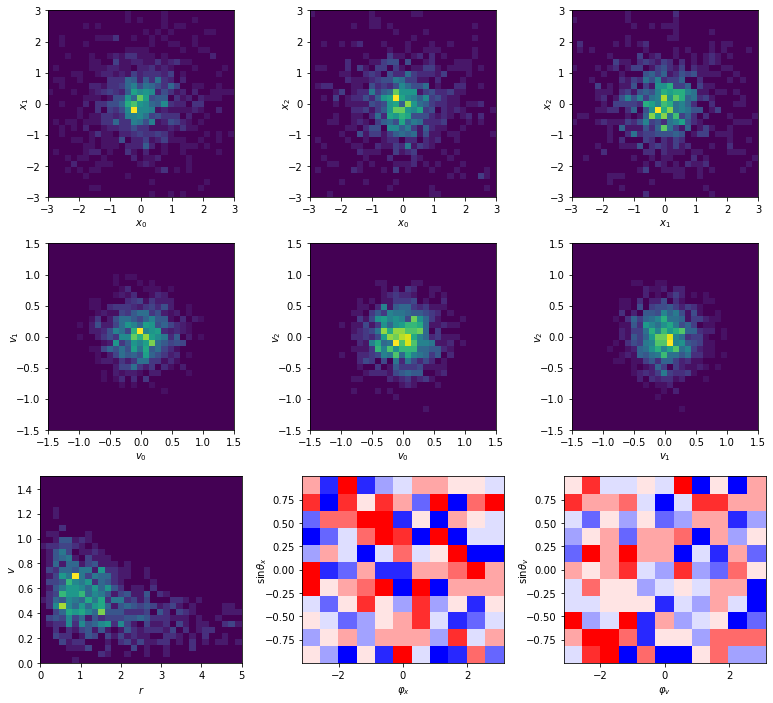

In [7]:
fig = plot_samples(data.numpy())
fig.savefig('plummer_df_samples.png', dpi=100)

Above, the first row of panels shows the spatial density of points, with one dimension projected out in each column. The second row shows the density of points in velocity space, projecting out one dimension in each column. The left panel of the third row shows the distribution of points in radius and speed. The middle panel of the last row shows how isotropically the points are distributed in space around the origin, while the right panel of the last row shows how isotropically points are distributed in velocity. As the number of samples goes to infinity, both panels should become white (perfect isotropy).

We can also compare the histogram of samples to the theoretical distribution function:

<ipython-input-8-6a092678cc28>:33: RuntimeWarning: divide by zero encountered in log
  img = np.log(n)


\int f(x,v) d^3x d^3v = 0.94287


<ipython-input-8-6a092678cc28>:69: RuntimeWarning: divide by zero encountered in true_divide
  img = (n_samp - n_0) / n_0
<ipython-input-8-6a092678cc28>:69: RuntimeWarning: invalid value encountered in true_divide
  img = (n_samp - n_0) / n_0
<ipython-input-8-6a092678cc28>:82: RuntimeWarning: divide by zero encountered in log
  np.log(n_samp) - np.log(n_0),
<ipython-input-8-6a092678cc28>:82: RuntimeWarning: invalid value encountered in subtract
  np.log(n_samp) - np.log(n_0),


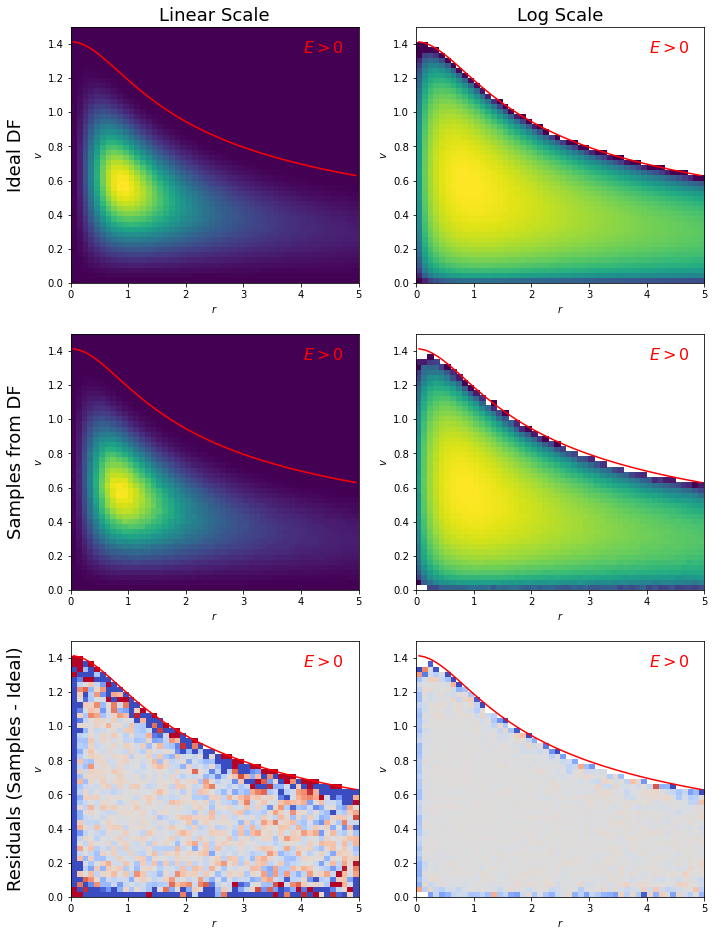

In [8]:
#Plots a histogram of the sample data as well as an ideal distribution
r_lim = (0., 5.)
v_lim = (0., 1.5)
bins = (50, 50)

r = np.linspace(r_lim[0], r_lim[1], bins[0]+1)
v = np.linspace(v_lim[0], v_lim[1], bins[1]+1)

r = 0.5 * (r[:-1] + r[1:])
v = 0.5 * (v[:-1] + v[1:])

rr,vv = np.meshgrid(r, v)

psi = 1. / np.sqrt(1+rr**2)
E = psi - vv**2 / 2
df = np.clip(E, 0., np.inf)**(7/2)
A = 24 * np.sqrt(2.) / (7 * np.pi**3)

n = A * (4*np.pi)**2 * rr**2 * vv**2 * df

fig,ax_arr = plt.subplots(3,2, figsize=(11,16))
fig.subplots_adjust(left=0.1)

# Ideal distribution
ax_arr[0,0].imshow(
    n,
    extent=r_lim+v_lim,
    origin='lower',
    aspect='auto',
    interpolation='nearest'
)

img = np.log(n)
vmax = np.max(img)
ax_arr[0,1].imshow(
    img,
    extent=r_lim+v_lim,
    vmax=vmax,
    vmin=vmax-10.,
    origin='lower',
    aspect='auto',
    interpolation='nearest'
)

dr = r[1] - r[0]
dv = v[1] - v[0]
N = np.sum(n) * dr * dv
print(f'\int f(x,v) d^3x d^3v = {N:.5f}')

# 2D histogram of samples
n_samples = 1024*1024*4
plummer_sphere = toy_systems.PlummerSphere()
x_samp,v_samp = plummer_sphere.sample_df(n_samples)
r_samp = np.sqrt(np.sum(x_samp**2, axis=1))
v_samp = np.sqrt(np.sum(v_samp**2, axis=1))

n_samp,_,_,_ = ax_arr[1,0].hist2d(r_samp, v_samp, bins=bins, range=[r_lim,v_lim])
n_samp = n_samp.T

ax_arr[1,1].hist2d(
    r_samp, v_samp,
    bins=bins,
    range=[r_lim,v_lim],
    norm=mcolors.LogNorm()
)

# Residuals (samples - ideal)
n_0 = n*dr*dv * n_samples
img = (n_samp - n_0) / n_0
ax_arr[2,0].imshow(
    img,
    extent=r_lim+v_lim,
    vmax=0.1,
    vmin=-0.1,
    origin='lower',
    aspect='auto',
    cmap='coolwarm_r',
    interpolation='nearest'
)

ax_arr[2,1].imshow(
    np.log(n_samp) - np.log(n_0),
    extent=r_lim+v_lim,
    vmax=1.,
    vmin=-1.,
    origin='lower',
    aspect='auto',
    cmap='coolwarm_r',
    interpolation='nearest'
)

# Zero-energy line
for a in ax_arr.flat:
    a.plot(r, np.sqrt(2.) * (1+r**2)**(-1/4), c='r')
    a.set_xlabel(r'$r$')
    a.set_ylabel(r'$v$')
    a.text(
        0.95, 0.95, r'$E > 0$',
        ha='right', va='top',
        fontsize=16, c='r',
        transform=a.transAxes
    )

# Labels
pos = ax_arr[0,0].get_position()
y_txt = 0.5 * (pos.y0 + pos.y1)
fig.text(
    0.02, y_txt,
    r'Ideal DF',
    rotation=90.,
    ha='left',
    va='center',
    fontsize=18,
)

pos = ax_arr[1,0].get_position()
y_txt = 0.5 * (pos.y0 + pos.y1)
fig.text(
    0.02, y_txt,
    r'Samples from DF',
    rotation=90.,
    ha='left',
    va='center',
    fontsize=18,
)

pos = ax_arr[2,0].get_position()
y_txt = 0.5 * (pos.y0 + pos.y1)
fig.text(
    0.02, y_txt,
    r'Residuals (Samples - Ideal)',
    rotation=90.,
    ha='left',
    va='center',
    fontsize=18,
)

ax_arr[0,0].set_title('Linear Scale', fontsize=18)
ax_arr[0,1].set_title('Log Scale', fontsize=18)

plt.show()

## Fit potential using ideal distribution function

We now verify that we recover the correct potential when we use the analytic distribution function (rather than a normalizing flow approximation). We use a model of the potential with a single free variable: the amplitude of the potential. The shape of the potential is correct.

In [9]:
#Analytical function that defines the spatially-varying potential excatly.
a = Variable(torch.Tensor([1.0]), requires_grad=True) # The correct value would be a = -1.
def phi_analytic(q):
    q2 = torch.sum(q**2, axis=1)
    return a / torch.sqrt(1 + q2)

The true distribution function:

In [10]:
#Generates the true distribution function.
def df_ideal(q, p):
    r2 = torch.sum(q**2, axis=1)
    v2 = torch.sum(p**2, axis=1)

    Phi = -(1+r2)**(-1/2)
    E = v2/2 + Phi

    f = torch.clamp(-E, 0, np.inf)**(7/2)

    A = 24 * np.sqrt(2.) / (7. * np.pi**3)

    return A * f

We calculate the gradients of the distribution function first:

In [11]:
#Number of phase-space sample coordinates
n_points = 1024 *1

#Generates generalized phase-space coordinates and relavent derivatives.
q,p = plummer_sphere.sample_df(n_points)
q = Variable(torch.from_numpy(q.astype('f4')), requires_grad=True)
p = Variable(torch.from_numpy(p.astype('f4')), requires_grad=True)

f = df_ideal(q, p)

df_dq = torch.autograd.grad(f, q,\
                            grad_outputs=torch.ones_like(f), retain_graph=True,\
                            create_graph=True)[0]
df_dp = torch.autograd.grad(f, p,\
                            grad_outputs=torch.ones_like(f), retain_graph=True,\
                            create_graph=True)[0]

Then, we plot the loss as a function of the amplitude $a$ of the potential. We add in different amounts of noise to the gradients of the distribution function, and see how that biases the best-fit value of $a$:

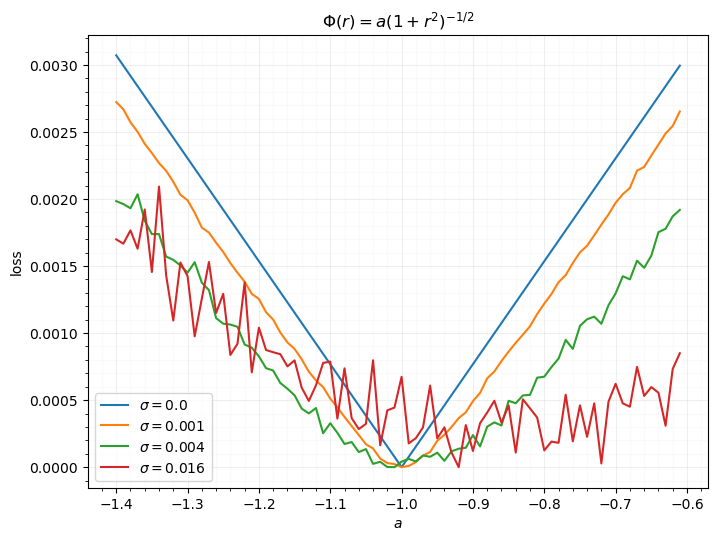

In [12]:
#Generates a grid from -1.4 to -.6 with .01 spacing.
a_range = torch.Tensor(np.arange(-1.4, -0.6, 0.01))

fig,ax = plt.subplots(1,1, figsize=(8,6), dpi=100)

#assigns numerical values for constants used in the Loss function.

lam = torch.Tensor([1.0])  # How much to penalize negative matter densities
mu = torch.Tensor([0.0])   # How much to penalize positive matter densities

phi_param = [a]

#Calculates the value of the loss function for various values of variance (sigma) in the derivatives and rescaling of the potential (a)
for err in [0., 0.001, 0.004, 0.016]:
    loss_range = []

    for aa in a_range:
        a.data = aa
        df_dq_est = df_dq + torch.normal(torch.zeros(df_dq.shape), torch.ones(df_dq.shape)*err)
        df_dp_est = df_dp + torch.normal(torch.zeros(df_dp.shape), torch.ones(df_dp.shape)*err)

        loss, dloss_dparam = potential_torch.get_phi_loss_gradients(
            phi_analytic, phi_param,
            q, p,
            df_dq=df_dq_est,
            df_dp=df_dp_est,
            weight_samples=False,
            lam=lam,
            mu=mu
        )

        loss_range.append(loss.detach().numpy())

    loss_range = np.array(loss_range)
    loss_range -= np.min(loss_range)
    ax.plot(a_range, loss_range, label=f'$\sigma = {err}$')

ax.legend()
ax.set_ylabel(r'loss')
ax.set_xlabel(r'$a$')
ax.set_title(r'$\Phi \left( r \right) = a \left( 1 + r^2 \right)^{-1/2}$')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.grid('on', which='major', alpha=0.2)
ax.grid('on', which='minor', alpha=0.05)

fig.savefig('phi_bias.png', dpi=120)
plt.show()

As the noise in $\frac{\partial f}{\partial \vec{\eta}}$ increases, the estimate of the amplitude $a$ of the potential becomes increasingly biased, in that it favors shallower potentials.

## Train ensemble of normalizing flows to represent the distribution function

We now train an ensemble of normalizing flows to approximate the distribution function, $f \left( \vec{\eta} \right)$. We first draw phase-space points from the true distribution function. Then, we train multiple normalizing flows on the same set of points.

The reason for training multiple normalizing flows, rather than just one, is to average down errors in the individual normalizing flows. In the end, we want to predict $\frac{\partial f}{\partial \vec{\eta}}$ as accurately as possible, because inaccurate estimates can bias our inferred gravitational potential.

Draw samples from the true distribution function. Filter out samples at $r > 10$, because these points produce massive gradients in the training procedure. Later on, we should deal with large gradients in a more automatic way (e.g., gradient clipping):

In [26]:
#Generates sample data
n_samples = 1024 * 128
data = sample_df(int(1.2 * n_samples), max_dist=10.0)
data = torch.Tensor(data[:n_samples,:])

Train multiple normalizing flows on the same dataset. Save each normalizing flow:

In [27]:
n_flows = 4

#n_flows = 960 # the directory plummer_flow already has an ensemble of 960 trained flows, 
               # skip the following cell if you do not wish to retrain the normalizing flows.

n_dim = 6
n_units = 4

n_epochs = 32
batch_size = 1024

n_steps = n_samples * n_epochs // batch_size
print(f'n_steps = {n_steps}')

n_steps = 4096


In [28]:
for i in range(n_flows):
    print(f'Training flow {i+1} of {n_flows} ...')
    #Initializes and trains the Normalizing Flow model (I think?)
    flow = flow_torch.NormalizingFlow(n_dim, n_units)
    loss_history = flow_torch.train_flow(
        flow, data, 
        n_epochs=n_epochs,
        batch_size=batch_size,
        callback=flow_torch.get_training_callback(
            flow,
            plt_fn=None,
            every=1024, 
        )
    )

    torch.save(flow.state_dict(), f'/Users/andyhicks/Desktop/REVU/deep-potential-master/plummer_flow_{i:02d}.pth')
       
    x_sample = flow.dist.sample(sample_shape=[128*1024])
    y_sample, _ = flow.backward(x_sample)
    fig = plot_samples(y_sample.detach().numpy())
    fig.savefig(f'plummer_flow_{i:02d}.png', dpi=100)
    plt.close(fig)

Training flow 1 of 4 ...
Step     1 of 4096: <loss> = 8.82210 , lr = 0.02
Step  1025 of 4096: <loss> = 5.14528 , lr = 0.01631
Step  2049 of 4096: <loss> = 5.12040 , lr = 0.01329
Step  3073 of 4096: <loss> = 5.12516 , lr = 0.01082
<loss> = 5.11973
training time: 563.7 s (0.1376 s/step)
Training flow 2 of 4 ...
Step     1 of 4096: <loss> = 9.73165 , lr = 0.02
Step  1025 of 4096: <loss> = 5.15375 , lr = 0.01631
Step  2049 of 4096: <loss> = 5.12776 , lr = 0.01329
Step  3073 of 4096: <loss> = 5.13587 , lr = 0.01082
<loss> = 5.12971
training time: 393.7 s (0.0961 s/step)
Training flow 3 of 4 ...
Step     1 of 4096: <loss> = 8.74973 , lr = 0.02
Step  1025 of 4096: <loss> = 5.16156 , lr = 0.01631
Step  2049 of 4096: <loss> = 5.14563 , lr = 0.01329
Step  3073 of 4096: <loss> = 5.13647 , lr = 0.01082
<loss> = 5.11401
training time: 390.2 s (0.0953 s/step)
Training flow 4 of 4 ...
Step     1 of 4096: <loss> = 9.16078 , lr = 0.02
Step  1025 of 4096: <loss> = 5.14812 , lr = 0.01631
Step  2049 of 40

### Test the accuracy of the gradients

First, draw a set of points $\vec{\eta}$ from the true distribution fuction $f$, and compute the gradient of the true distribution w.r.t. $\vec{\eta}$ at each point:
$$
  \frac{\partial f}{\partial \vec{\eta}} \, .
$$

In [29]:
n_points = 1024 * 1

#Generates phase-space data within a sphere of finite radius

q,p = plummer_sphere.sample_df(n_points)
q = Variable(torch.Tensor(q.astype('f4')), requires_grad=True)
p = Variable(torch.Tensor(p.astype('f4')), requires_grad=True)

#Calculates the derivatives and defines the idealized distribution function from these sample data points.

f_ideal, df_dq, df_dp = potential_torch.calc_df_deta(df_ideal, q, p)

Then, compute the gradients of the best-fit approximation to the distribution function $f^{\ast}$ w.r.t. $\vec{\eta}$ at each point:
$$
  \frac{\partial f^{\ast}}{\partial \vec{\eta}} \, .
$$
We calculate the gradients using each normalizing flow in our ensemble, and take the mean of the results:

In [30]:
#Combines x,v information into a single vector in phase-space
eta = torch.cat([q,p], axis=1)

#Initializes the arrays of proper size and populates them with zeroes.
f_star_list, dflow_dq_list, dflow_dp_list = [], [], []
f_star = np.zeros_like(f_ideal.detach().numpy())
dflow_dq = np.zeros_like(df_dq.detach().numpy())
dflow_dp = np.zeros_like(df_dp.detach().numpy())

for i in range(n_flows):
    print(f'Loading flow {i+1} of {n_flows} ...')
    
    #Loads flow data and assigns it to the variable 'flow'
    fname = f'/Users/andyhicks/Desktop/REVU/deep-potential-master/plummer_flow_{i:02d}.pth'
    state_dict = torch.load(fname)
    flow = flow_torch.NormalizingFlow(n_dim, n_units)
    flow.load_state_dict(state_dict)

    #Indexes the flow data over the previously defined phase-space and raises it to an exponential (I think?)
    def get_f_star(q, p):
        eta = torch.cat([q,p], axis=1)
        _ , prior_logprob, log_det = flow(eta)
        c = prior_logprob + log_det
        return torch.exp(c)
    
    #Generates the data for f* and its derivatives.
    res = potential_torch.calc_df_deta(get_f_star, q, p)
    f_star_list.append(res[0].detach().numpy())
    dflow_dq_list.append(res[1].detach().numpy())
    dflow_dp_list.append(res[2].detach().numpy())

    f_star += res[0].detach().numpy() / n_flows
    dflow_dq += res[1].detach().numpy() / n_flows
    dflow_dp += res[2].detach().numpy() / n_flows

print('Done.')

Loading flow 1 of 4 ...
Loading flow 2 of 4 ...
Loading flow 3 of 4 ...
Loading flow 4 of 4 ...
Done.


Plot the true vs. estimated gradients:

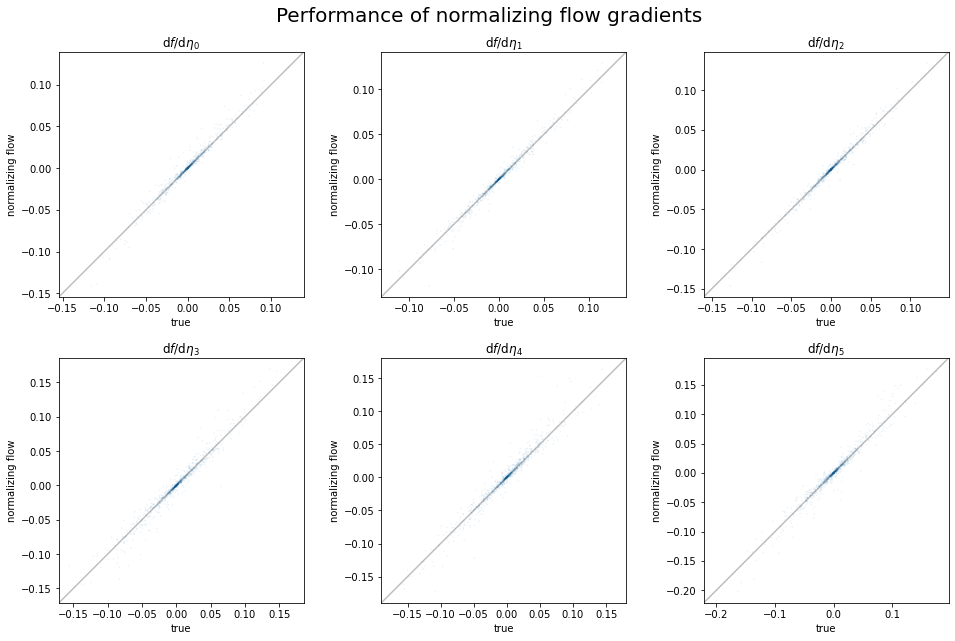

In [31]:
fig,ax_arr = plt.subplots(2,3, figsize=(16,9))

#Returns the mean value of the passed array (I think?)
def sigma_clipped_mean(x, n_sigma=3.):
    #Computes the STD deviation for the x array
    sigma = np.std(x, axis=0)
    #Computes the median value for the x array
    mu = np.median(x, axis=0)
    idx = np.abs(x - mu[None,...]) < n_sigma*(sigma[None,...]+1.e-8)
    w = idx.astype(x.dtype)
    x_avg = np.sum(x*w, axis=0) / np.sum(w, axis=0)
    return x_avg

#Returns the mean value of the derivates
df_dq_est = sigma_clipped_mean(np.stack(dflow_dq_list, axis=0), n_sigma=5)
df_dp_est = sigma_clipped_mean(np.stack(dflow_dp_list, axis=0), n_sigma=5)

#Plots the computed values for the derivatives against true values
for i,ax in enumerate(ax_arr.flat):
    ax.set_aspect('equal')
    if i < 3:
        ax.scatter(
            #
            df_dq[:,i].detach(),
            df_dq_est[:,i],
            alpha=0.1, s=2,
            edgecolors='none'
        )
    else:
        ax.scatter(
            df_dp[:,i-3].detach(),
            df_dp_est[:,i-3],
            alpha=0.1, s=2,
            edgecolors='none'
        )

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xlim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)

    ax.plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], c='k', alpha=0.25)

    ax.set_xlabel(r'true')
    ax.set_ylabel(r'normalizing flow')

    ax.set_title(rf'$\mathrm{{d}}f / \mathrm{{d}}\eta_{i}$')

fig.subplots_adjust(
    hspace=0.25, wspace=0.3,
    top=0.91, bottom=0.06
)
fig.suptitle('Performance of normalizing flow gradients', fontsize=20)

fig.savefig('flow_gradients_comparison.png', dpi=100)

Plot a histogram of the gradient residuals along each dimension in phase space:

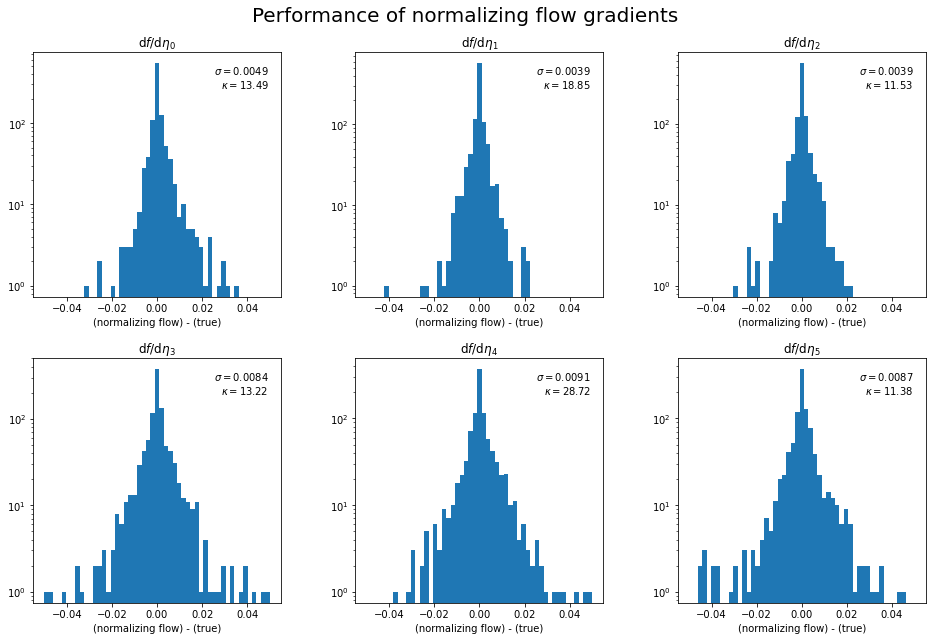

In [32]:
fig,ax_arr = plt.subplots(2,3, figsize=(16,9))

for i,ax in enumerate(ax_arr.flat):
    ax.set_aspect('auto')
    if i < 3:
        resid = df_dq_est[:,i] - df_dq[:,i].detach().numpy()
    else:
        resid = df_dp_est[:,i-3] - df_dp[:,i-3].detach().numpy()
    
    ax.hist(
        resid,
        range=(-0.05, 0.05),
        bins=51,
        log=True
    )
    ax.set_xlabel(r'(normalizing flow) - (true)')
    ax.set_title(rf'$\mathrm{{d}}f / \mathrm{{d}}\eta_{i}$')

    sigma = np.std(resid)
    kurt = scipy.stats.kurtosis(resid)
    ax.text(
        0.95, 0.95,
        rf'$\sigma = {sigma:.4f}$'+'\n'+rf'$\kappa = {kurt:.2f}$',
        ha='right',
        va='top',
        transform=ax.transAxes
    )

fig.subplots_adjust(
    hspace=0.25, wspace=0.3,
    top=0.91, bottom=0.06
)
fig.suptitle('Performance of normalizing flow gradients', fontsize=20)

fig.savefig('flow_gradients_comparison_hist.png', dpi=100)

### Calculating the normalized deviance from ideal.

The following cell calculates the standard deviation from the ideal case.

In [41]:
print(df_dq)

tensor([[ 0.0586,  0.0063,  0.0185],
        [ 0.0022,  0.0017,  0.0152],
        [-0.0014,  0.0178, -0.0233],
        ...,
        [-0.0081, -0.0105,  0.0184],
        [ 0.0189, -0.0161, -0.0128],
        [-0.0256,  0.0166,  0.0319]], grad_fn=<MulBackward0>)


In [44]:
STD_dev = 0
STD_sum = 0
for i in range(0,3):
    sub_data = torch.subtract(torch.from_numpy(df_dq_est[:,i]),df_dq[:,i].detach())

print(sub_data)

        

tensor([-0.0058, -0.0004,  0.0006,  ..., -0.0023, -0.0001,  0.0064])


### Fitting one-parameter model using estimated gradients of DF

We now fit the simple, one-parameter analytic model of the potential, using the gradients estimated using our normalizing flows. We fit the model using the gradients calculated from the individual flows, and also using the ensemble of flows.

In [ ]:
a_range = torch.Tensor(np.arange(-1.2, -0.2, 0.01))

fig,ax = plt.subplots(1,1, figsize=(8,6), dpi=100)

lam = torch.Tensor([1.0])
mu = torch.Tensor([0.0])
    
phi_param = [a]

for i in range(n_flows+1):
    loss_range = []
    
    if i < n_flows:
        df_dq_i = dflow_dq_list[i]
        df_dp_i = dflow_dp_list[i]
        alpha = 0.1
        label = f'individual flows' if i == 0 else None
    else:
        df_dq_i = dflow_dq
        df_dp_i = dflow_dp
        alpha = 1.0
        label = 'mean'
    
    for aa in a_range:
        a.data = aa

        loss, dloss_dparam = potential_torch.get_phi_loss_gradients(
            phi_analytic, phi_param,
            q, p,
            df_dq=torch.Tensor(df_dq_i),
            df_dp=torch.Tensor(df_dp_i),
            weight_samples=False,
            lam=lam,
            mu=mu
        )

        loss_range.append(loss.detach().numpy())

    loss_range = np.array(loss_range)
    loss_range -= np.min(loss_range)
    ax.plot(a_range, loss_range, label=label, c='b', alpha=alpha)

ax.set_ylabel(r'loss')
ax.set_xlabel(r'$a$')
ax.set_title(r'$\Phi \left( r \right) = a \left( 1 + r^2 \right)^{-1/2}$')

ax.legend()

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid('on', which='major', alpha=0.2)
ax.grid('on', which='minor', alpha=0.05)

fig.savefig('phi_bias.png', dpi=120)
plt.show()

We can see that the result we get using the mean of the normalizing flows has a much smaller bias than the result we get using the individual normalizing flows.

## Generate training dataset using ensemble of flows

Pack the data as an array of shape `(sample, X, 3)`, where $X \in \left\{ q, p, \frac{\partial f}{\partial q} , \frac{\partial f}{\partial p} \right\}$. This data will be used to fit the gravitational potential.

In [ ]:
n_data = q.shape[0]
data = torch.stack([q, p, torch.Tensor(dflow_dq), torch.Tensor(dflow_dp)], axis=1)

if torch.cuda.is_available():
    data = data.cuda()
    lam = lam.cuda()
    mu = mu.cuda()
    
batch_size = 1024
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,\
                                           shuffle=True)


# Fit full model of $\Phi \left( \vec{q} \right)$

Finally, we fit a flexible model of the potential to the gradients estimated from the ensemble of normalizing flows. We will use a simple feed-forward neural network:

In [ ]:
phi_model = potential_torch.PhiNN(n_dim=3, n_hidden=3, n_features=128)

if torch.cuda.is_available():
    phi_model = phi_model.cuda()

phi_param = [p for p in phi_model.parameters() if p.requires_grad==True]
n_variables = sum([int(np.prod(np.array(list(param.shape)))) for param in phi_param])
print(f'{n_variables} variables in the gravitational potential model.')


A function to plot the potential:

In [ ]:
def plot_model(phi_model, x, v, q):
        
    Phi = phi_model(q)

    r = np.sqrt(np.sum(x**2, axis=1))
    Phi_ideal = plummer_sphere.phi(r)

    Phi_0 = np.median(Phi_ideal - Phi.detach().cpu().numpy())
    Phi += Phi_0

    fig,ax = plt.subplots(1,1, figsize=(8,6))

    r_range = np.linspace(0.05, 50., 1000)
    ax.semilogx(
        r_range,
        plummer_sphere.phi(r_range),
        c='g', alpha=0.2,
        label='ideal'
    )
    ax.scatter(r, Phi.detach().cpu(), alpha=0.2, s=3, label='NN model')
    ax.legend(loc='upper left')

    ax.set_xlim(0.05, 50.)
    ax.set_ylim(-1.4, 0.4)

    ax.set_xlabel(r'$r$')
    ax.set_ylabel(r'$\Phi$')

    return fig

Train the model:

In [ ]:
# Number of training epochs
n_epochs = 4096

# How much to weight Laplacian in loss function
lam = torch.Tensor([2.0])  # Penalty for negative matter densities
mu = torch.Tensor([0.])   # Penalty for positive matter densities

if torch.cuda.is_available():
    lam = lam.cuda()
    mu = mu.cuda()
    
# Optimizer
from flow_torch import RAdam
n_steps = n_epochs * (n_data // batch_size)
print(f'{n_steps} steps planned.')

opt = RAdam(phi_param, lr=5e-2)
decayRate = 0.9992
lr_schedule = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=decayRate)
 
# Optimze
loss_history = []
t0 = time()
i = 0

x_plot,v_plot = plummer_sphere.sample_df(1024)
q_plot = torch.Tensor(x_plot.astype('f4'))
if torch.cuda.is_available():
    q_plot = q_plot.cuda()
        
for e in range(n_epochs):
    for batch_idx, b in enumerate(train_loader):
        q_b, p_b, df_dq_b, df_dp_b = [
            torch.squeeze(x) for x in torch.split(b, 1, dim=1)
        ]
        
        # Calculate the loss and its gradients w.r.t. the parameters        
        loss, dloss_dparam = potential_torch.get_phi_loss_gradients(
            phi_model, phi_param,
            q_b, p_b,
            df_dq=df_dq_b,
            df_dp=df_dp_b,
            lam=lam,
            mu=mu,
            weight_samples=False
        )

        phi_model.zero_grad()
        loss.backward(retain_graph=True, create_graph=False)
        opt.step()
        opt.zero_grad()
        
        i += 1
        
        if i % 10 == 0:
            lr_schedule.step()
            
        # Logging
        loss_history.append(loss.detach().cpu())

        if (i % 128 == 0) or (i == n_steps - 1):
            loss_avg = np.mean(loss_history[-128:])
            lr = opt.param_groups[0]['lr'] 
            print(
                f'Step {i+1} of {n_steps} : '
                f'<loss> = {loss_avg:.5g} '
                f'lr = {lr:.5g}'
            )
        
t1 = time()
print(f'Elapsed time: {t1-t0:.1f} s')


In [ ]:
# save models
torch.save(phi_model.state_dict(), 'plummer_sphere_phi.pth')

In [ ]:
w = np.kaiser(250,5)
w /= np.sum(w)
loss_conv = np.hstack([
    np.repeat(loss_history[0], 125),
    np.array(loss_history),
    np.array(loss_history)[-125:][::-1]
])
loss_conv = np.convolve(loss_conv, w, mode='valid')
plt.semilogy(np.arange(len(loss_history)), loss_history, alpha=0.1)
plt.semilogy(np.arange(len(loss_conv)), loss_conv)
plt.grid('on', which='major', alpha=0.25)
plt.grid('on', which='minor', alpha=0.05)
plt.ylabel('loss (smoothed)')
plt.xlabel('training step')
plt.savefig('loss.png', dpi=100)
plt.show()

In [ ]:
def plot_phi(phi_nn, q):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(13,4))#, subplot_kw=dict(aspect='auto'))

    if torch.cuda.is_available():
        q = q.cuda()
        
    # phi vs. r
    r = torch.sqrt(torch.sum(q**2, axis=1))
            
    phi_r = phi_nn(q).detach().cpu().numpy()
    phi_theory_r = plummer_sphere.phi(r.detach().cpu().numpy())
    phi_0 = np.median(phi_r - phi_theory_r)
    
    r_max = 8.

    r_range = np.linspace(0.01, r_max, 100)
    phi_theory_r = plummer_sphere.phi(r_range)
    ax1.scatter(r.detach().cpu(), phi_r-phi_0, alpha=0.05, s=3)
    ax1.plot(r_range, phi_theory_r, c='g', alpha=0.5)
    ax1.set_xlabel(r'$r$')
    ax1.set_ylabel(r'$\phi$')
    ax1.set_xlim(0., r_max)
    ax1.set_ylim(-1.1, 0.2)

    # phi in (x,y)-plane
    x = np.linspace(-r_max, r_max, 50)
    y = np.linspace(-r_max, r_max, 50)
    xlim = (x[0], x[-1])
    ylim = (y[0], y[-1])
    x,y = np.meshgrid(x, y)
    s = x.shape
    x.shape = (x.size,)
    y.shape = (y.size,)
    xyz = np.stack([x,y,np.zeros_like(x)], axis=1)
    q_grid = Variable(torch.Tensor(xyz.astype('f4')), requires_grad=True)
    
    if torch.cuda.is_available():
        q_grid = q_grid.cuda()
        
    phi_img = phi_nn(q_grid).detach().cpu().numpy()
    phi_img = np.reshape(phi_img, s)
    ax2.imshow(phi_img, extent=xlim+ylim)
    ax2.set_xlabel(r'$x$')
    ax2.set_ylabel(r'$y$')
    ax2.set_title(r'$\phi$')

    # log(rho) in (x,y)-plane
    p_grid = Variable(torch.Tensor(np.random.normal(size=q_grid.shape)), requires_grad=True)
    
    if torch.cuda.is_available():
        p_grid = p_grid.cuda()
        
    _,rho_img = potential_torch.calc_phi_derivatives(phi_nn, q_grid)
    rho_img = np.reshape(rho_img.detach().cpu().numpy(), s)
    ax3.imshow(np.log(rho_img), extent=xlim+ylim)
    ax3.set_xlabel(r'$x$')
    ax3.set_yticklabels([])
    # ax3.set_ylabel(r'$y$')
    ax3.set_title(r'$\ln \, \rho$')

    return fig

In [ ]:
fig = plot_phi(phi_model, q[:1000])
fig.savefig('phi_rho.png', dpi=150)
plt.show()

In [ ]:
!ffmpeg -y -r 10 -pattern_type glob -i 'phi_training_*.png' -c:v libx264 -vf fps=10 -pix_fmt yuv420p phi_training.mp4

In [ ]:
np.random.uniform()

In [ ]:
t1 = time()
print(f'Elapsed time: {t1-t0:.1f} s')